# Import libraries

In [ ]:
!pip install tensorflow

In [ ]:
!pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt

from glob import glob

import shutil
import tensorflow as tf
from skimage.io import imread
from google.colab import drive
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Sentiment classifier'

In [ ]:
# get the folders inside the path
os.listdir(os.path.join(path))

['happy', 'sad', 'Images_split']

# Splitting in folders

In [ ]:
import random
random.seed(42)
happy_images = glob(os.path.join(path,'happy','/*'))
random.shuffle(happy_images)
sad_images = glob(os.path.join(path,'sad','/*'))
random.shuffle(sad_images)

In [ ]:
happy_images = glob(os.path.join(path,'/happy','/*'))
len(os.listdir(os.path.join(path,'happy')))

878

In [ ]:
len(sad_images)

27

Splitting data into train and test

In [ ]:
len_train = int(0.7*(len(happy_images) + len(sad_images)))
len_validation = int(0.15*(len(happy_images) + len(sad_images)))
len_test = int(0.15*(len(happy_images) + len(sad_images)))
total_len = len(happy_images) + len(sad_images)

In [ ]:
import math
def train_validation_test(classes_names, classes_images, len_train, len_validation, len_test, total_len, path):
    l_l = [len_train, len_test, len_validation]
    p,a = 0,0
    for folder_name, len_list in zip(['train', 'test', 'validation'], [len_train, len_test, len_validation]):
        for class_name, images in zip(classes_names, classes_images):
            os.makedirs(os.path.join(path, 'Images_split', folder_name, class_name), exist_ok=True)

            start_index = int(len(images) / total_len * (sum(l_l[:a])))
            end_index = int(len(images) / total_len * (sum(l_l[:a+1])))

            for i in range(start_index, end_index):
                if os.path.exists(images[i]):
                    dest_path = os.path.join(path, 'Images_split', folder_name, class_name, os.path.basename(images[i]))
                    shutil.copyfile(images[i], dest_path)
                else:
                    print(f"File not found: {images[i]}")
            p += 1
            a = math.floor(p/2)
            print(f'p:{p},a:{a}')


In [ ]:
train_validation_test(['happy','sad'],[happy_images,sad_images],len_train,len_validation,len_test,total_len,path)

Start index:0,End index:614
p:1,a:0
Start index:0,End index:327
p:2,a:1
Start index:614,End index:745
p:3,a:1
Start index:327,End index:398
p:4,a:2
Start index:745,End index:877
p:5,a:2
Start index:398,End index:468
p:6,a:3


# Citire imagini

In [ ]:
images_training = tf.keras.utils.image_dataset_from_directory(os.path.join(path,'Images_split','train'), label_mode='binary', seed = 42)
images_validation = tf.keras.utils.image_dataset_from_directory(os.path.join(path,'Images_split','validation'), label_mode='binary', seed = 42)
images_testing = tf.keras.utils.image_dataset_from_directory(os.path.join(path,'Images_split','test'), label_mode='binary', seed = 42)

Found 941 files belonging to 2 classes.
Found 202 files belonging to 2 classes.
Found 202 files belonging to 2 classes.


In [ ]:
# normalization of images
X_training = images_training.map(lambda x, y: x/255)
y_training = images_training.map(lambda x, y: y)
X_validation = images_validation.map(lambda x, y: x/255)
y_validation =  images_validation.map(lambda x, y: y)
X_testing = images_testing.map(lambda x, y: x/255)
y_testing = images_testing.map(lambda x, y: y)

In [ ]:
batch = images_training.as_numpy_iterator().next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

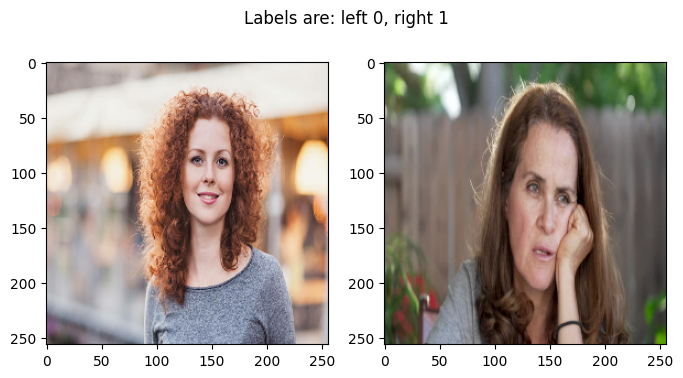

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(batch[0][0].astype("int16"))
ax2.imshow(batch[0][28].astype("int16"))
fig.suptitle(f'Labels are: left {int(batch[1][0])}, right {int(batch[1][28])}')
plt.show()

# Type 1 feature: pretrained VGG model

In [ ]:
images = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Sentiment classifier_data', label_mode='binary', seed = 42)

Found 1347 files belonging to 2 classes.


In [ ]:
X_img = images.map(lambda x,y:x/255)
y_img = images.map(lambda x,y:y)

In [ ]:
def get_y(y_tensor):
  y_labels = []
  for y in y_tensor:
    y_labels.append(y)
  return np.vstack(y_labels)

In [ ]:
y_labels = get_y(y_img)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [ ]:
# include_top=False to exclude the fully connected layers at the top.
vgg_model = VGG16(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet', pooling='max')
vgg_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
features_train,features_validation,features_test = vgg_model.predict(X_training),vgg_model.predict(X_validation),vgg_model.predict(X_testing)
features_data = np.concatenate((features_train,features_validation),axis=0)
y_train = get_y(y_training)
y_valid = get_y(y_validation)
y_test = get_y(y_testing)
y_data = np.concatenate((y_train,y_valid),axis=0)

7/7 [==============================] - 272s 20s/step


Random Forest supervised learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100,random_state = 42,class_weight = 'balanced')
rf.fit(features_train, y_train)
y_pred = rf.predict(features_validation)

<ipython-input-17-0d1c3ee4f8d5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(features_train, y_train)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       131
         1.0       1.00      0.01      0.03        71

    accuracy                           0.65       202
   macro avg       0.83      0.51      0.41       202
weighted avg       0.77      0.65      0.52       202



In [ ]:
batch = images_validation.as_numpy_iterator().next()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':['balanced']
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=rf_grid, cv=5, scoring='recall')
grid_search.fit(features_data, np.squeeze(y_data))

print('Best parametrs:', grid_search.best_params_)

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(features_data, y_data)
y_pred = best_model.predict(features_test)

print(classification_report(np.squeeze(get_y(y_test)), y_pred))

<ipython-input-32-3384783b0e00>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(features_data, y_data)


              precision    recall  f1-score   support

         0.0       0.63      0.86      0.73       131
         1.0       0.25      0.08      0.13        71

    accuracy                           0.59       202
   macro avg       0.44      0.47      0.43       202
weighted avg       0.50      0.59      0.52       202



In [ ]:
r = recall_score(y_test,y_pred,average=None)
f = f1_score(y_test,y_pred,average=None)
p = precision_score(y_test,y_pred,average=None)
original_dict = {'recall':r,'f1_score':f,'precision':p}

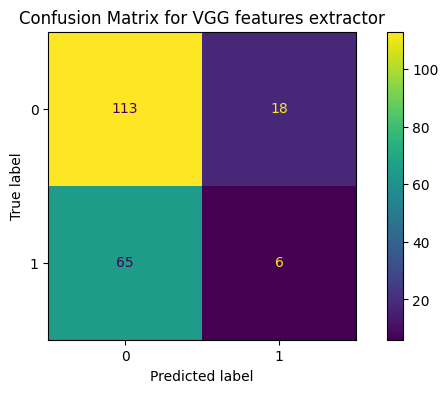

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(values_format='d',ax=ax)
ax.set_title('Confusion Matrix for VGG features extractor')
plt.show()

# SMOTE algorithm for the imbalanced data problem

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
count_l = Counter(np.squeeze(y_data))
smote = SMOTE()
features_smote, y_smote = smote.fit_resample(features_data,y_data)
count_smote_l = Counter(np.squeeze(y_smote))
print(count_l,count_smote_l)

Counter({0.0: 746, 1.0: 397}) Counter({0.0: 746, 1.0: 746})


In [ ]:
# Random Forest with the updated dataset oversampled with SMOTE
best_model.fit(features_smote, y_smote)
y_pred = best_model.predict(features_test)

In [ ]:
features_test.shape

(202, 512)

In [ ]:
rf.fit(features_smote, y_smote)
y_pred = rf.predict(features_test)

In [ ]:
len(y_pred)

202

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.80      0.73       131
         1.0       0.45      0.30      0.36        71

    accuracy                           0.62       202
   macro avg       0.56      0.55      0.55       202
weighted avg       0.60      0.62      0.60       202



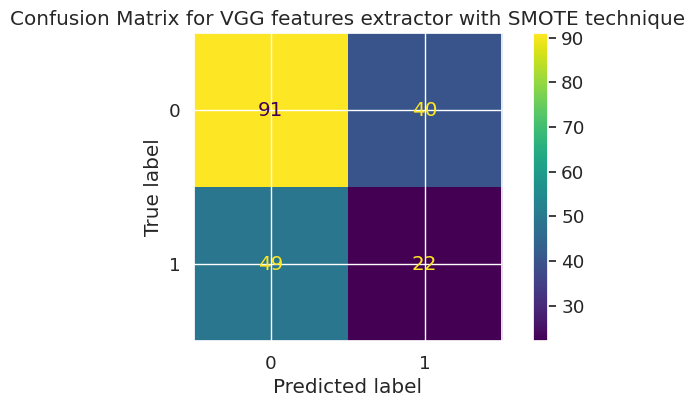

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(values_format='d',ax=ax)
ax.set_title('Confusion Matrix for VGG features extractor with SMOTE technique')
plt.show()

In [ ]:
r = recall_score(y_test,y_pred,average=None)
f = f1_score(y_test,y_pred,average=None)
p = precision_score(y_test,y_pred,average=None)
smote_dict = {'recall':r,'f1_score':f,'precision':p}

In [ ]:
original_dict

{'recall': array([0.86259542, 0.08450704]),
 'f1_score': array([0.73139159, 0.12631579]),
 'precision': array([0.63483146, 0.25      ])}

In [ ]:
smote_dict

{'recall': array([0.80152672, 0.29577465]),
 'f1_score': array([0.73426573, 0.3559322 ]),
 'precision': array([0.67741935, 0.44680851])}

In [ ]:
new_dict = {}
for key,value in original_dict.items():
  if key in smote_dict:
    new_dict[key] = np.concatenate((value[1:], smote_dict[key][1:]))
new_dict

{'recall': array([0.08450704, 0.29577465]),
 'f1_score': array([0.12631579, 0.3559322 ]),
 'precision': array([0.25      , 0.44680851])}

In [ ]:
score_df_smote = pd.DataFrame(new_dict)
score_df_smote['resample'] = ['original','smote']

In [ ]:
score_df_smote

,recall,f1_score,precision,resample
0,0.084507,0.126316,0.250000,original
1,0.295775,0.355932,0.446809,smote


<ipython-input-88-c1c8c82d82f7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="resample", y="recall", data=score_df_smote, palette='viridis', order=["original", "smote"])


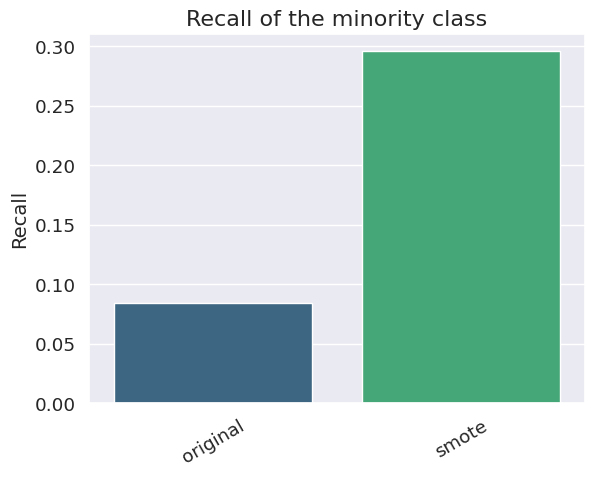

In [ ]:
sns.set(font_scale=1.2)
#g = sns.FacetGrid(score_df_smote, height=5)
sns.barplot(x="resample", y="recall", data=score_df_smote, palette='viridis', order=["original", "smote"])
plt.xticks(rotation=30)

plt.xlabel(' ')
plt.ylabel('Recall', fontsize=14)

plt.title('Recall of the minority class', fontsize=16)

plt.show()

# Dummy Classifier

In [ ]:
# random classifier
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy ='stratified')
dc.fit(features_data, y_data)
y_pred = dc.predict(features_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67       131
         1.0       0.35      0.31      0.33        71

    accuracy                           0.56       202
   macro avg       0.50      0.50      0.50       202
weighted avg       0.55      0.56      0.55       202



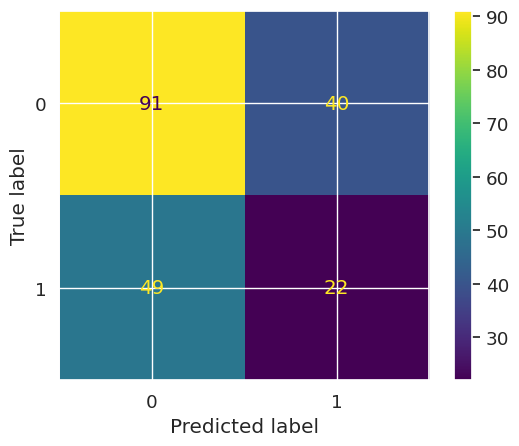

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(values_format='d')

# Agglomerative clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import KNeighborsClassifier

agg_cluster = AgglomerativeClustering(n_clusters=2)
agg_cluster = agg_cluster.fit_predict(features_smote)

knn = KNeighborsClassifier()
knn.fit(features_smote,np.squeeze(agg_cluster))
y_pred = knn.predict(features_test)


In [ ]:
silhouette_avg = silhouette_score(features_smote, agg_cluster)
silhouette_avg

0.019706778

In [ ]:
len(y_pred)

202

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.83      0.75       131
         1.0       0.46      0.27      0.34        71

    accuracy                           0.63       202
   macro avg       0.57      0.55      0.54       202
weighted avg       0.60      0.63      0.60       202



Hyperparameter tuning

In [ ]:
def find_best_parameters(features, param):
    max_score = 0
    best_parameters = None
    score = []

    for n_clusters in param:
      agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
      c_labels = agg_cluster.fit_predict(features)

      silhouette_score1 = silhouette_score(features, c_labels)
      print(f'N_Clusters: {n_clusters}, silhouette score= {silhouette_score1}')
      score.append(silhouette_score1)

      if silhouette_score1 > max_score:
          max_score = silhouette_score1
          best_parameters = n_clusters

    return best_parameters, max_score,score

In [ ]:
from sklearn.metrics import silhouette_score
params = [2, 3, 4, 5, 6, 7, 8, 9, 10]
param_vgg,best_score_vgg,score_vgg = find_best_parameters(features_smote,params)

N_Clusters: 2, silhouette score= 0.01970677822828293
N_Clusters: 3, silhouette score= 0.01820567063987255
N_Clusters: 4, silhouette score= 0.023441363126039505
N_Clusters: 5, silhouette score= 0.009276690892875195
N_Clusters: 6, silhouette score= 0.015593133866786957
N_Clusters: 7, silhouette score= 0.019411854445934296
N_Clusters: 8, silhouette score= 0.02094019390642643
N_Clusters: 9, silhouette score= 0.024584494531154633
N_Clusters: 10, silhouette score= 0.010786245577037334


# HDBScan

In [ ]:
!pip install hdbscan


  Using cached hdbscan-0.8.33.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039282 sha256=9d3846ce4fdfc6325eb65fdeae5742c411f1c25577bf2200adc674961857ab3a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [ ]:
import hdbscan
def find_best_parameters_hdbscan(features, params):
    max_score = 0
    best_min_cluster_size = None
    score = []

    for param in params:
      hdb = hdbscan.HDBSCAN(min_cluster_size=param)

      c_labels = hdb.fit_predict(features)

      silhouette_score1 = silhouette_score(features, c_labels)
      print(f"min_cluster_size: {param}; silhouette score= {silhouette_score1}")
      score.append(silhouette_score1)

      if silhouette_score1 > max_score:
          max_score = silhouette_score1
          best_min_cluster_size = param
    return best_params, max_score, score

In [ ]:
params = [3,5,10]
best_params, best_score, score = find_best_parameters_hdbscan(features_smote,params)

min_cluster_size: 3; silhouette score= -0.15405674278736115
min_cluster_size: 5; silhouette score= -0.1903485655784607
min_cluster_size: 10; silhouette score= -0.17824070155620575


In [ ]:
l_hdb = hdbscan.HDBSCAN(min_cluster_size=3).fit_predict(features_data)
unique_labels, label_counts = np.unique(l_hdb, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label -1: 844 occurrences
Label 0: 296 occurrences
Label 1: 3 occurrences


In [ ]:
mask = l_hdb != -1
features_filtered = features_data[mask]
labels_filtered = l_hdb[mask]

In [ ]:
silhouette_score(features_data, l_hdb)

-0.017364172

In [ ]:
knn = KNeighborsClassifier()
knn.fit(features_filtered,np.squeeze(labels_filtered))
y_pred = knn.predict(features_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       131
         1.0       0.00      0.00      0.00        71

    accuracy                           0.64       202
   macro avg       0.32      0.49      0.39       202
weighted avg       0.42      0.64      0.51       202



# Type 2 : HOG feature extraction

In [ ]:
from skimage import io
from sklearn.utils import shuffle
from skimage import io, transform,color,feature
from skimage.feature import hog

def load_images_and_labels(directory, label):
  images = []
  labels = []

  for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    image = io.imread(image_path)
    resized_image = transform.resize(image, (200,200))
    if len(image.shape) == 3:
      images.append(resized_image)
      labels.append(label)

  return images, labels


In [ ]:
def shuffle_images(sad_directory,happy_directory):
  sad_images, sad_labels = load_images_and_labels(sad_directory, label=1)
  happy_images, happy_labels = load_images_and_labels(happy_directory, label=0)
  all_images = np.array(sad_images + happy_images)
  all_labels = np.array(sad_labels + happy_labels)

  shuffled_images, shuffled_labels = shuffle(all_images, all_labels, random_state=42)
  return shuffled_images,shuffled_labels

In [ ]:
train_images,train_labels = shuffle_images(os.path.join(path,'Images_split/train/sad/'),os.path.join(path,'Images_split/train/happy/'))
val_images,val_labels = shuffle_images(os.path.join(path,'Images_split/validation/sad/'),os.path.join(path,'Images_split/validation/happy/'))
test_images,test_labels = shuffle_images(os.path.join(path,'Images_split/test/sad/'),os.path.join(path,'Images_split/test/happy/'))

In [ ]:
train_val_images,train_val_labels = np.concatenate([train_images,val_images]),np.concatenate([train_labels,val_labels])

In [ ]:
def get_hog_features(dataset):
  images_hog = []
  for image in dataset:
    image = color.rgb2gray(image)
    features= hog(image, orientations=15, pixels_per_cell=(15, 15),
                        cells_per_block=(2, 2), visualize=False, block_norm="L1", transform_sqrt=False,multichannel=False)
    images_hog.append(features)
  return images_hog

In [ ]:
hog_images = get_hog_features(train_val_images)

<ipython-input-77-62260ccc2058>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features= hog(image, orientations=15, pixels_per_cell=(15, 15),


In [ ]:
hog_images_test = get_hog_features(test_images)

<ipython-input-77-62260ccc2058>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features= hog(image, orientations=15, pixels_per_cell=(15, 15),


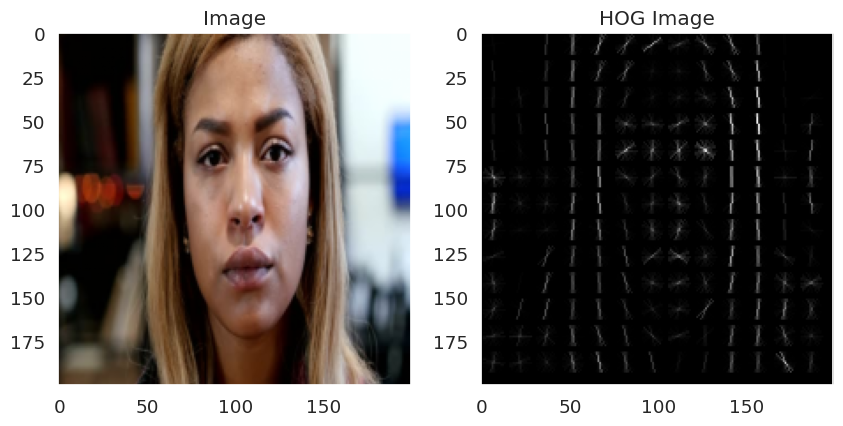

In [ ]:
import matplotlib.pyplot as plt
resized_image = transform.resize(train_val_images[188], (200,200))
image1 = color.rgb2gray(resized_image)
hog_feature, hog_image= hog(image1, orientations=15, pixels_per_cell=(15, 15), cells_per_block=(2, 2), visualize=True, block_norm="L2", transform_sqrt=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.imshow(resized_image, cmap=plt.cm.gray)
ax1.set_title('Image')

ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('HOG Image')

ax1.grid(False)
ax2.grid(False)
plt.show()

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
count_l = Counter(np.squeeze(train_val_labels))
smote = SMOTE()
features_smote_hog, y_smote_hog = smote.fit_resample(hog_images,train_val_labels)
count_smote_l = Counter(np.squeeze(y_smote_hog))

Counter({0: 745, 1: 391}) Counter({1: 745, 0: 745})


In [ ]:
# Random Forest with the updated dataset oversampled with SMOTE
best_model = grid_search.best_estimator_
best_model.fit(features_smote_hog, y_smote_hog)
y_pred = best_model.predict(hog_images_test)

In [ ]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77       130
           1       0.50      0.19      0.27        69

    accuracy                           0.65       199
   macro avg       0.59      0.54      0.52       199
weighted avg       0.62      0.65      0.60       199



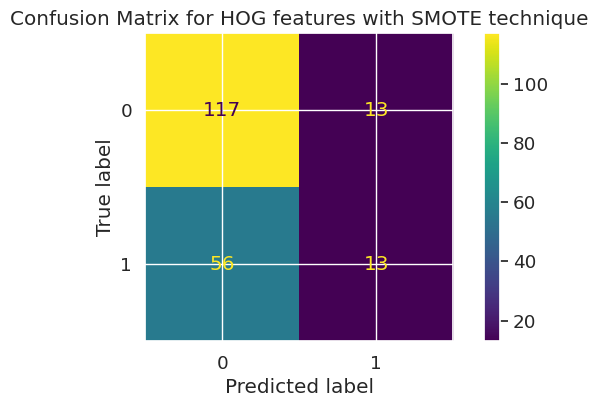

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cm = confusion_matrix(test_labels, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(values_format='d',ax=ax)
ax.set_title('Confusion Matrix for HOG features with SMOTE technique')
plt.show()

# Dummy Classifier

In [ ]:
# random classifier
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy ='stratified')
dc.fit(features_smote_hog, y_smote_hog)
y_pred = dc.predict(hog_images_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       130
           1       0.35      0.41      0.37        69

    accuracy                           0.53       199
   macro avg       0.50      0.50      0.50       199
weighted avg       0.55      0.53      0.54       199



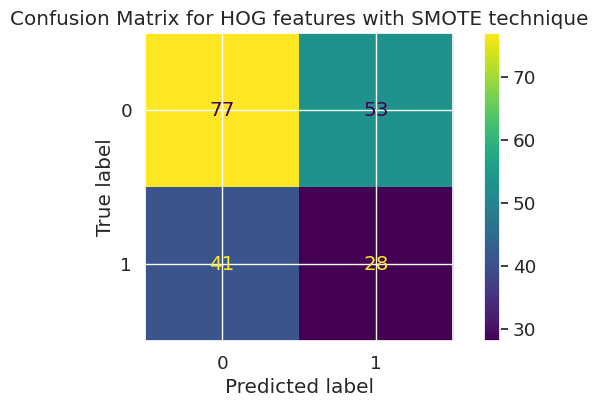

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cm = confusion_matrix(test_labels, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(values_format='d',ax=ax)
ax.set_title('Confusion Matrix for HOG features with SMOTE technique')
plt.show()

# Agglomerative clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import KNeighborsClassifier


agg_cluster = AgglomerativeClustering(n_clusters=2)
agg_cluster = agg_cluster.fit_predict(features_smote_hog)

knn = KNeighborsClassifier()
knn.fit(features_smote_hog,np.squeeze(agg_cluster))
y_pred = knn.predict(hog_images_test)


In [ ]:
silhouette_avg = silhouette_score(features_smote_hog, agg_cluster)
silhouette_avg

0.06640717438966126

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       130
           1       0.41      0.10      0.16        69

    accuracy                           0.64       199
   macro avg       0.54      0.51      0.47       199
weighted avg       0.57      0.64      0.56       199



Hyperparameter tuning

In [ ]:
def find_best_parameters(features, param):
  max_score = 0
  best_parameters = None
  score=[]

  for n_clusters in param:

      agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)

      c_labels = agg_cluster.fit_predict(features)

      silhouette_score1 = silhouette_score(features, c_labels)
      score.append(silhouette_score1)
      print(f'N_Clusters: {n_clusters}, silhouette score= {silhouette_score1}')

      if silhouette_score1 > max_score:
          max_score = silhouette_score1
          best_parameters = n_clusters

  return best_parameters, max_score,score

In [ ]:
from sklearn.metrics import silhouette_score
params = [2, 3, 4, 5, 6, 7, 8, 9, 10]
param,best_score_hog, score_hog = find_best_parameters(features_smote_hog,params)

N_Clusters: 2, silhouette score= 0.06640717438966126
N_Clusters: 3, silhouette score= 0.020031316887042905
N_Clusters: 4, silhouette score= 0.022545057042491694
N_Clusters: 5, silhouette score= 0.0024705879724183314
N_Clusters: 6, silhouette score= 0.0050161262043732675
N_Clusters: 7, silhouette score= -0.009207340714351041
N_Clusters: 8, silhouette score= -0.01835494545115921
N_Clusters: 9, silhouette score= -0.016499872543846578
N_Clusters: 10, silhouette score= -0.015073258836502222


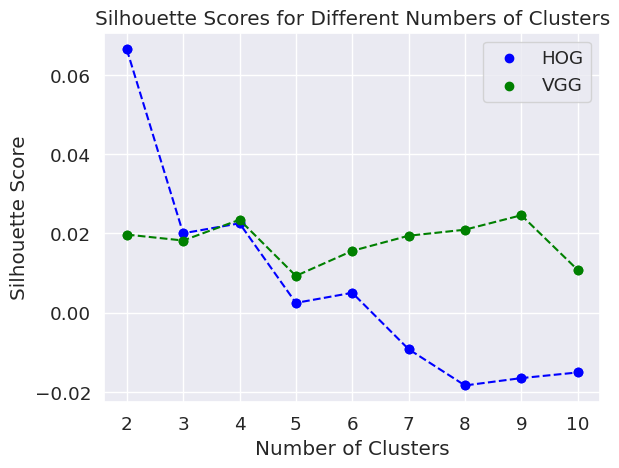

In [ ]:
n_clusters_list = [2,3,4,5,6,7,8,9,10]
plt.scatter(n_clusters_list, score_hog, c="blue", label="HOG")
plt.scatter(n_clusters_list, score_vgg, c="green", label="VGG")

plt.plot(n_clusters_list, score_hog, linestyle="--", marker="o", color="blue")
plt.plot(n_clusters_list, score_vgg, linestyle="--", marker="o", color="green")

plt.legend()
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()

# HDBScan

In [ ]:
import hdbscan
def find_best_parameters_hdbscan(features, params):
  max_score = 0
  best_min_cluster_size = None
  score = []

  for param in params:

      hdb = hdbscan.HDBSCAN(min_cluster_size=param)

      c_labels = hdb.fit_predict(features)

      silhouette_score1 = silhouette_score(features, c_labels)
      print(f"min_cluster_size: {param}; silhouette score= {silhouette_score1}")
      score.append(silhouette_score1)

      if silhouette_score1 > max_score:
          max_score = silhouette_score1
          best_min_cluster_size = param
  return best_params, max_score, score

In [ ]:
params = [3,5,10]
best_params_hog, best_score_hog, score_hog = find_best_parameters_hdbscan(features_smote_hog,params)

min_cluster_size: 3; silhouette score= -0.16629732845624193
min_cluster_size: 5; silhouette score= -0.19507680299087007
min_cluster_size: 10; silhouette score= -0.1982295646955114


In [ ]:
l_hdb = hdbscan.HDBSCAN(min_cluster_size=17).fit_predict(features_smote_hog)
unique_labels, label_counts = np.unique(l_hdb, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label -1: 1442 occurrences
Label 0: 30 occurrences
Label 1: 18 occurrences


In [ ]:
knn = KNeighborsClassifier()
knn.fit(features_smote_hog,np.squeeze(l_hdb))
y_pred = knn.predict(hog_images_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.61      0.13      0.22       130
           1       0.35      0.16      0.22        69

    accuracy                           0.14       199
   macro avg       0.32      0.10      0.15       199
weighted avg       0.52      0.14      0.22       199



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


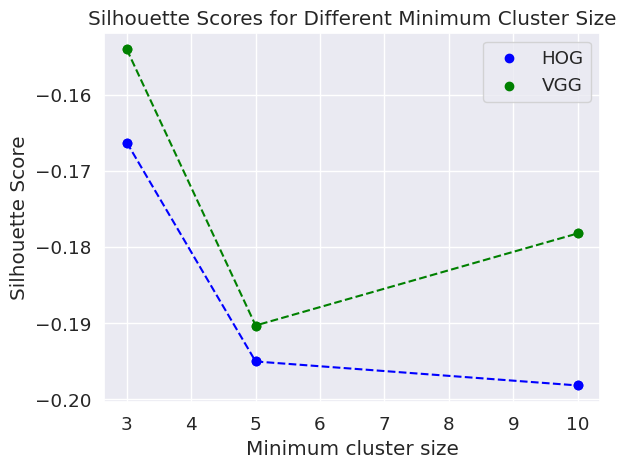

In [ ]:
params = [3,5,10]
plt.scatter(params, score_hog, c="blue", label="HOG")
plt.scatter(params, score, c="green", label="VGG")

plt.plot(params, score_hog, linestyle="--", marker="o", color="blue")
plt.plot(params, score, linestyle="--", marker="o", color="green")

plt.legend()
plt.title('Silhouette Scores for Different Minimum Cluster Size')
plt.xlabel('Minimum cluster size')
plt.ylabel('Silhouette Score')

plt.show()